# Linear regression model to predict used car prices using Vehicle dataset from Kaggle:

##Dataset

https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv

# Imports & loading the data.

In [76]:
import pandas as pd
import numpy as np

In [77]:
# Getting the data
cars= pd.read_csv('/content/Car details v3.csv')

## Taking an initial look at the data.

In [78]:
cars.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [79]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


**Most features are objects that need to be cast to numerical values if possible before modeling.**

In [80]:
cars.name.value_counts() 

Maruti Swift Dzire VDI               129
Maruti Alto 800 LXI                   82
Maruti Alto LXi                       71
BMW X4 M Sport X xDrive20d            62
Maruti Swift VDI                      61
                                    ... 
Maruti Swift Dzire AMT ZXI             1
Maruti Esteem Vxi - BSIII              1
Maruti Swift 1.2 DLX (Only Delhi)      1
Toyota Corolla Altis 1.8 Sport         1
Honda Jazz Basic                       1
Name: name, Length: 2058, dtype: int64

**Need to drop the name column for the high variation in values and unfeasibility of cleaning or aggregation.**

In [81]:
cars = cars.drop('name', axis= 1) # Dropping  name col.

In [82]:
cars.columns

Index(['year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'engine', 'max_power', 'torque',
       'seats'],
      dtype='object')

In [83]:
cars.owner.value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

#EDA

In [84]:
# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style

%matplotlib inline

### What cars are the most expensive? (Visualization)

<BarContainer object of 8128 artists>

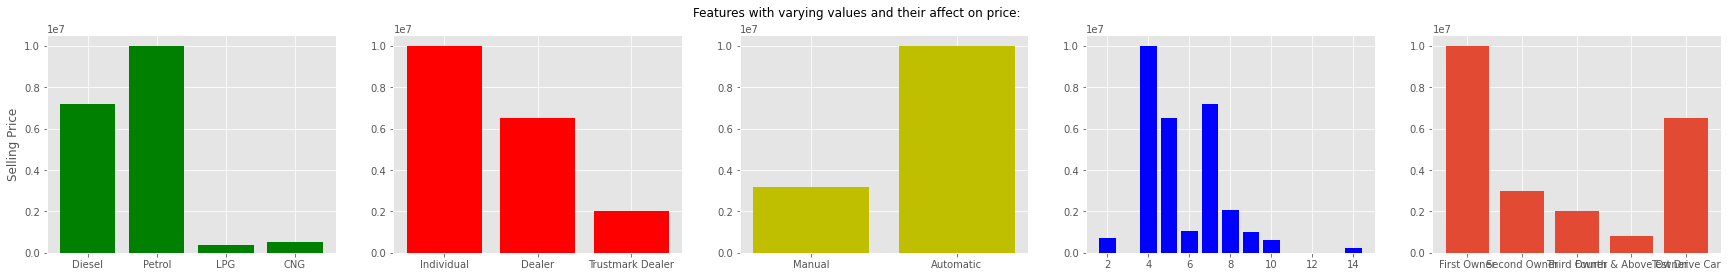

In [85]:
style.use('ggplot')

fig = plt.figure(figsize=(30,4))
fig.suptitle('Features with varying values and their affect on price:')
plt.subplot(1,5,1)
plt.bar(cars.fuel, cars.selling_price, color= 'g')
plt.ylabel('Selling Price')

plt.subplot(1,5,2)
plt.bar(cars.seller_type, cars.selling_price, color= 'r')

plt.subplot(1,5,3)
plt.bar(cars.transmission, cars.selling_price, color= 'y')

plt.subplot(1,5,4)
plt.bar(cars.seats,cars.selling_price, color= 'b')

plt.subplot(1,5,5)
plt.bar(cars.owner,cars.selling_price)

**Fuel**: We can see that cars running on petrol are the most expensive. Followed closely by diesel, with CNG and LPG signigicantly cheaper price.

**Seller type**: Buying a used car from individuals seems like the most expensive option. dealers almost a third cheaper, and trustmark as an option seems the cheapest.

**Transmission**: Cars with manual transmission are third the price of cars with automatic.

**Seats**: Cars with 4 passenger capacity seem the most expensive which makes sense since most luxury cars are designed with a rear center console dividing the car into 4 seats. 

**Owner**: The price decreases as the car is resold which makes sense. And test drive cars are still the second most expensive following 1st owner which is understandable because test cars are subjected to hardships to **Test the reliability.**

**Note: cars with more than 8 seats are uncommon (outliers) and may need dropping or imputing in the Data cleaning process.**

In [86]:
cars.seats[cars.seats > 8].value_counts().sum() # Rows that we are considering to drop or impute.

100

In [87]:
cars.shape

(8128, 12)

### Let's get the percentage these outliers represent. **(sum of outliers / total rows) x 100**

In [88]:
print(round((cars.seats[cars.seats > 8].value_counts().sum() / cars.shape[0]) * 100, ndigits=3,),'%')

1.23 %


Since these outliers represent only 1 percent of our data, we can drop them.

### Taking a look at missing values before moving on to **Data cleaning.**

In [89]:
cars.isna().sum() #Get an idea of columns with missing values.

year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

In [90]:
cars.isna().sum().sum() # the sum of all missing values.

1100

In [91]:
print(round((cars.isna().sum().sum() / cars.shape[0]) * 100 , ndigits= 3) ,'%') # Getting the precentage these rows represent.

13.533 %


Obviously we can't drop these rows. Unless these missing values are in the same rows, we will need to impute.

In [92]:
cars.owner.value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

In [93]:
cars.seller_type.value_counts()

Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64

In [94]:
cars.fuel.value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

## Data cleaning

In [95]:
cars.head(1)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0


###Encoding owner, transmision, seller, and fuel columns

###Importing label encdoer

In [96]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [97]:
cars.owner= le.fit_transform(cars.owner)
cars.seller_type= le.fit_transform(cars.seller_type)
cars.fuel= le.fit_transform(cars.fuel)
cars.transmission= le.fit_transform(cars.transmission)

In [98]:
cars.drop(columns=['engine','torque'],inplace= True, axis=1)
# we drop torque and engine because they convey the same idea as max_power

###Extracting numerical data from objects.

In [99]:
cars.mileage = cars.mileage.str.extract('(\d+)', expand=False)

cars.max_power = cars.max_power.str.extract('(\d+)', expand=False)


In [100]:
cars.head(1)

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,max_power,seats
0,2014,450000,145500,1,1,1,0,23,74,5.0


In [101]:
cars.columns

Index(['year', 'selling_price', 'km_driven', 'fuel', 'seller_type',
       'transmission', 'owner', 'mileage', 'max_power', 'seats'],
      dtype='object')

In [102]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           8128 non-null   int64  
 1   selling_price  8128 non-null   int64  
 2   km_driven      8128 non-null   int64  
 3   fuel           8128 non-null   int64  
 4   seller_type    8128 non-null   int64  
 5   transmission   8128 non-null   int64  
 6   owner          8128 non-null   int64  
 7   mileage        7907 non-null   object 
 8   max_power      7912 non-null   object 
 9   seats          7907 non-null   float64
dtypes: float64(1), int64(7), object(2)
memory usage: 635.1+ KB


###Turning objects into numpy floats

In [103]:
cars.mileage= cars.mileage.astype(np.float)
cars.max_power= cars.max_power.astype(np.float)
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           8128 non-null   int64  
 1   selling_price  8128 non-null   int64  
 2   km_driven      8128 non-null   int64  
 3   fuel           8128 non-null   int64  
 4   seller_type    8128 non-null   int64  
 5   transmission   8128 non-null   int64  
 6   owner          8128 non-null   int64  
 7   mileage        7907 non-null   float64
 8   max_power      7912 non-null   float64
 9   seats          7907 non-null   float64
dtypes: float64(3), int64(7)
memory usage: 635.1 KB


###Drop missing values

In [104]:
cars.shape

(8128, 10)

In [105]:
cars.dropna(inplace= True) #drop 2.7% of data that is na

In [106]:
cars.shape

(7906, 10)

###Impute outliers

In [107]:
cars.seats.value_counts()

5.0     6254
7.0     1120
8.0      235
4.0      133
9.0       80
6.0       62
10.0      19
2.0        2
14.0       1
Name: seats, dtype: int64

In [108]:
cars.describe()

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,max_power,seats
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,1.888313,0.889831,0.868328,0.790159,18.981027,91.271060,5.416393
std,3.863695,8.135827e+05,5.679230e+04,1.001478,0.397182,0.338155,1.205767,4.064364,35.732781,0.959208
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,32.000000,2.000000
25%,2012.000000,2.700000e+05,3.500000e+04,1.000000,1.000000,1.000000,0.000000,16.000000,68.000000,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,1.000000,1.000000,1.000000,0.000000,19.000000,82.000000,5.000000
75%,2017.000000,6.900000e+05,9.542500e+04,3.000000,1.000000,1.000000,2.000000,22.000000,102.000000,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,3.000000,2.000000,1.000000,4.000000,42.000000,400.000000,14.000000


We notice that the mean and median are equal. We can impute using either.

In [109]:
cars[cars.seats > 8] = round(cars.seats.median())

## Further visualization

###Relationship between features and target variable

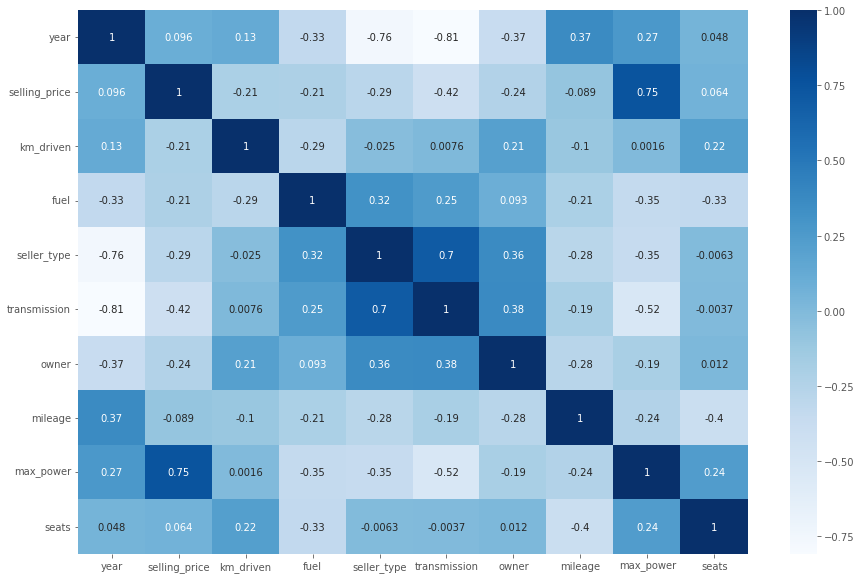

In [111]:
plt.figure(figsize=(15,10))
sns.heatmap(cars.corr(), annot= True, cmap= 'Blues');

### max_power (Horse power) seems to have the highest correlation with our target variable (selling_price). Realistically, km_driven should be the highest. Maybe it's because the dataset is not real or we are wrong.

###Relationship between features to detect multicollinearity

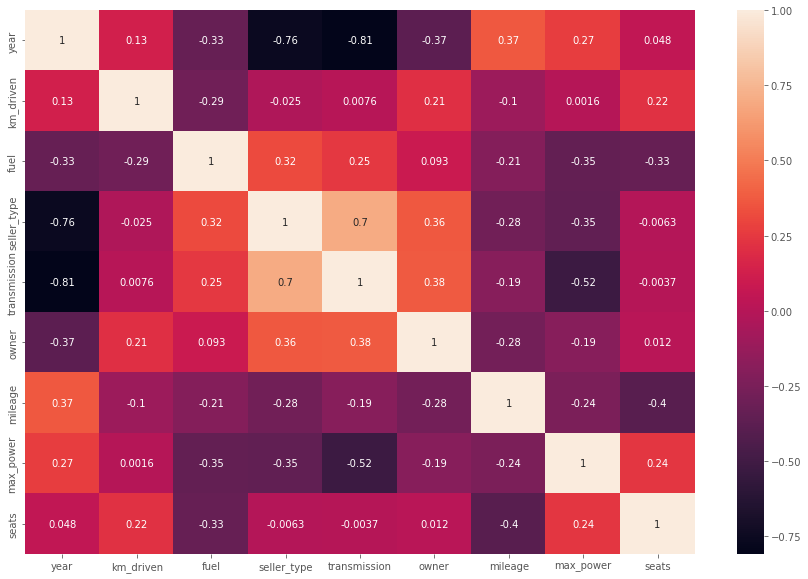

In [112]:
plt.figure(figsize=(15,10))
sns.heatmap(cars.drop('selling_price',axis= 1).corr(), annot= True);

### It looks like we have strong multicollinearity. We will wait to see the statistical significance of each feature when we get to "Statsmodels Regression"

# Modeling

## Train test split

In [113]:
from sklearn.model_selection import train_test_split

In [114]:
X= cars.drop('selling_price', axis= 1) # storing the features
y= cars.selling_price # storing target

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Feature scaling

In [116]:
from sklearn.preprocessing import StandardScaler # importting scaler
ss= StandardScaler() # Instanciating StandardScaler

In [117]:
X_train_scaled= ss.fit_transform(X_train) # Scaling training features
X_test_scaled= ss.transform(X_test) # Scaling testing features

**Note:** We fit and transformed training set and only transformed testing set to prevent data leakage.

## Importing scoring metrics

In [118]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

##Statsmodles Regression

In [119]:
import statsmodels.api as sm

In [120]:
stat = sm.OLS(y,X, data= cars)
sml= stat.fit()

In [121]:
sml_pred= sml.predict(X_test)

### Statsmodels: Model evaluation

In [122]:
sml.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          selling_price   R-squared (uncentered):                   0.777
Model:                            OLS   Adj. R-squared (uncentered):              0.777
Method:                 Least Squares   F-statistic:                              3055.
Date:                Wed, 12 Jan 2022   Prob (F-statistic):                        0.00
Time:                        18:09:50   Log-Likelihood:                     -1.1482e+05
No. Observations:                7906   AIC:                                  2.297e+05
Df Residuals:                    7897   BIC:                                  2.297e+05
Df Model:                           9                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
year          -849.2210     33.308    -25.496      0.000    -914.514    -783.928
km_driven       -1.9440      0.111    -17.590      0.000      -2.161      -1.727
fuel          5.086e+04   6366.012      7.990      0.000    3.84e+04    6.33e+04
seller_type  -6.242e+04   1.36e+04     -4.586      0.000   -8.91e+04   -3.57e+04
transmission   -1.6e+05   1.58e+04    -10.100      0.000   -1.91e+05   -1.29e+05
owner        -2.205e+04   4914.130     -4.486      0.000   -3.17e+04   -1.24e+04
mileage       3.741e+04   1772.057     21.109      0.000    3.39e+04    4.09e+04
max_power     1.771e+04    183.820     96.339      0.000    1.73e+04    1.81e+04
seats         5.212e+04   7882.506      6.612      0.000    3.67e+04    6.76e+04
==============================================================================
Omnibus:                     4334.358   Durbin-Watson:                   1.567
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            73980.236
Skew:                           2.254   Prob(JB):                         0.00
Kurtosis:                      17.292   Cond. No.                     2.91e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.91e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [123]:
cars['Error']= cars.selling_price - sml_pred

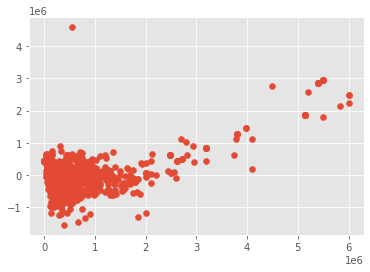

In [124]:
plt.scatter(cars.selling_price, cars.Error)

In [125]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Lasso regression

In [148]:
from sklearn import linear_model # Importing the linear_model that contains lasso
lasso_reg = linear_model.Lasso(alpha= 30, max_iter= 100, tol= 0.1) # Instanciating lasso

### Fitting the model

In [149]:
lasso_reg.fit(X_train_scaled, y_train) # fitting the model to training set

Lasso(alpha=30, max_iter=100, tol=0.1)

### Making the prediction

In [150]:
lasso_pred= lasso_reg.predict(X_test_scaled)

###Model evaluation

checking score on both training and testing set to look for overfitting

In [151]:
round(lasso_reg.score(X_test_scaled, y_test), ndigits=3)

0.676

In [152]:
round(lasso_reg.score(X_train_scaled, y_train),ndigits=3)

0.664

In [153]:
print('SCORE: ' ,lasso_reg.score(X_test_scaled, y_test))
print('MSE: ' ,mean_squared_error(y_test, lasso_pred))
print('MAE: ' ,mean_absolute_error(y_test, lasso_pred))
print('RMAE: ' ,np.sqrt(mean_absolute_error(y_test, lasso_pred)))

SCORE:  0.6764033153726259
MSE:  226400500962.51303
MAE:  272923.2871268818
RMAE:  522.4206036584716


## Random forests regression

In [132]:
from sklearn.ensemble import RandomForestRegressor # Importing RandomForestRegressor
rf= RandomForestRegressor() # Instanciating RandomForestRegressor

In [133]:
rf.fit(X_train, y_train)

RandomForestRegressor()

####Making the prediction

In [134]:
rf_pred= rf.predict(X_test)

###Model evaluation

In [135]:
print('SCORE: ' ,rf.score(X_test, y_test))
print('MSE: ' ,mean_squared_error(y_test, rf_pred))
print('MAE: ' ,mean_absolute_error(y_test, rf_pred))
print('RMAE: ' ,np.sqrt(mean_absolute_error(y_test, rf_pred)))

SCORE:  0.9817512248061855
MSE:  12767534533.270605
MAE:  63769.50457644383
RMAE:  252.52624532203347


##In the end, the model that provided the most satisfactory result is Random Forest regressor.

#Thank you for listening!